In [1]:
import os
import numpy as np
import cv2
import json
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torchvision.utils import make_grid

In [2]:
from matplotlib.pyplot import imshow, figure
import matplotlib as mpl

def view_image(ii, dpi=100, nrow=4):
    mpl.rcParams['figure.dpi'] = dpi
    if len(ii.shape) == 3:        
        imshow(ii)
        return
    t = torch.from_numpy(ii)
    t = t.permute(0, 3, 1, 2)
    n = make_grid(t,padding=4,pad_value=255, nrow=nrow)
    imshow(n.numpy().transpose(1,2,0))

def view_gray(ii, dpi=100, nrow=4):
    mpl.rcParams['figure.dpi'] = dpi
    if len(ii.shape) == 2:   
        imshow(ii, cmap='gray')
        return
    t = torch.from_numpy(ii).unsqueeze(-1)
    t = t.permute(0, 3, 1, 2)
    n = make_grid(t, padding=4, pad_value=255,nrow=nrow)
    imshow(n.numpy().transpose(1,2,0), cmap='gray')

datapath = Path('/data/private/dataset/clevr/CLEVR_0')
datapath = Path('/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/')


/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0.json
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_mask.png


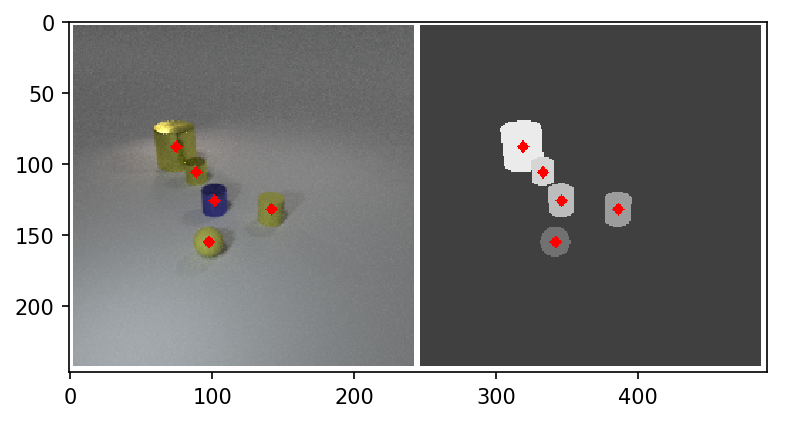

In [35]:
idx = 0
imgpath = list(datapath.glob('{}*.png'.format(idx)))
annpath = datapath / '{}.json'.format(idx)

with open(annpath, 'r') as f:
    ann = json.load(f)
print(annpath)
img = []
for i in imgpath:
    print(i)
    img.append(cv2.imread(str(i)))
imgs = np.stack(img)
# view_image(imgs, 100)
# Object center locations
ii = imgs.copy()
for a in ann['objects']:
    x = a['pixel_coords'][0]
    y = a['pixel_coords'][1]
    for i in ii:
        i = cv2.circle(i, (x, y), 2, (255,0,0), 4)

view_image(ii,150)

In [4]:
def convert_to_srgb(val):
    if val <= 0.0031308:
        return val * 12.92
    else:
        return 1.055 * (val**(1.0 / 2.4)) - 0.055

sphere [95, 152, 8.696335792541504]
cylinder [139, 129, 10.005647659301758]
cylinder [99, 123, 10.424165725708008]
cylinder [86, 103, 12.091879844665527]
cylinder [72, 85, 13.118249893188477]
[113 156 188 213 235]


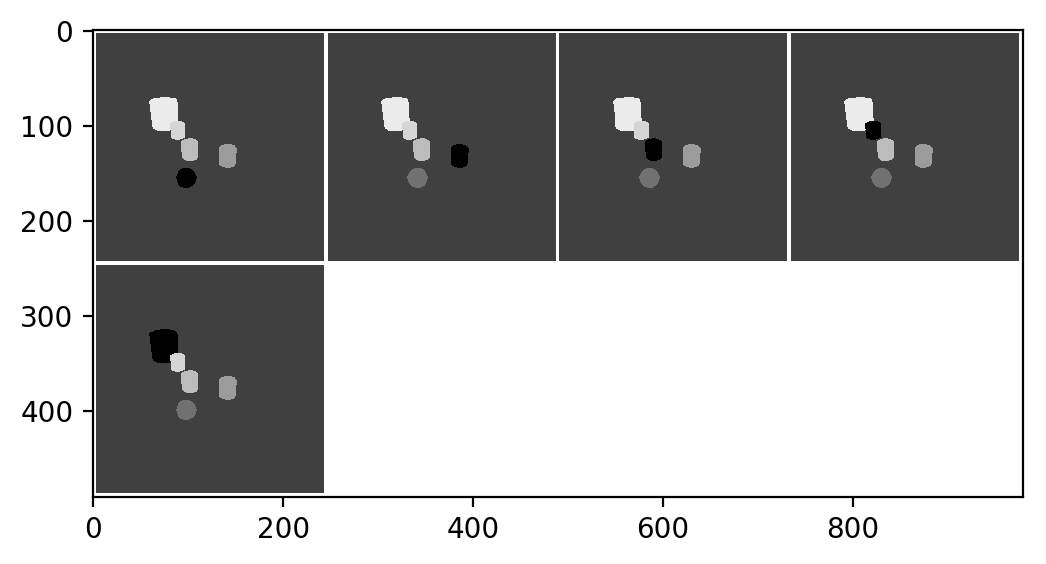

In [36]:
for o in ann['objects']:
    print(o['shape'], o['pixel_coords'])
print(np.array(ann['colormap']))
mask = np.stack([imgs[1]] * len(ann['objects'])) # 64 is the background color
#cnt = dict(zip(*np.unique(mask[0], return_counts=True)))
#del cnt[0]
#print(cnt)

for i, k in enumerate(ann['colormap']):
    # mask[i, mask[i] != k] = 0
    mask[i, mask[i] == k] = 0
view_image(mask,200)

In [17]:
# Note that the procedures below assumes that imgs are already sorted by z depth
# Closer object gets lower index

# Create binary masking of each objects.
subs = imgs.copy()[1:]
n = subs.shape[0]
subs = np.vstack(subs)
subs = cv2.cvtColor(subs, cv2.COLOR_BGR2GRAY)
subs = subs.reshape(n, 240, 240)
subs = subs - np.stack([subs[0]] * n)
mask = subs > 200
subs[mask] = 0
idx = np.where(np.logical_and(subs > 100, subs< 200))
subs[idx] = 255

# Occlusion by objects in front
masks = subs.copy().astype(np.int16)
for i in range(masks.shape[0]-1):
    masks[i+1] -= np.abs(masks[i])
masks = masks.astype(np.uint8)[1:]
view_gray(masks,100)


ZeroDivisionError: float division by zero

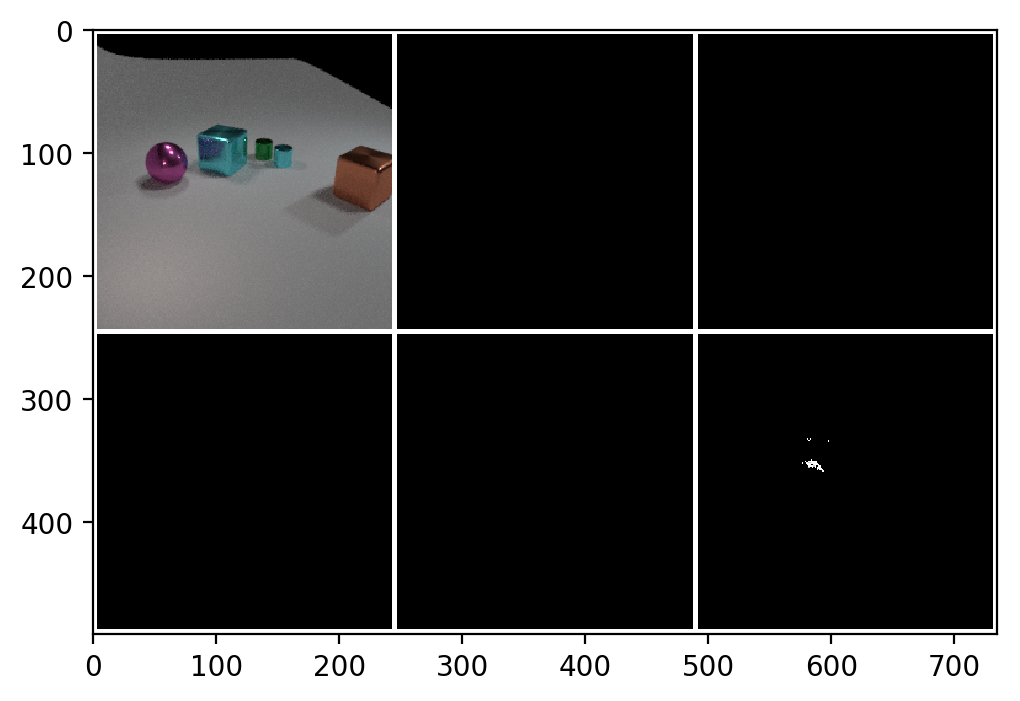

In [71]:
rgb_mask = np.stack([masks] * 3, -1)
full = np.concatenate([np.expand_dims(imgs[0],0), rgb_mask])
view_image(full,200,nrow=3)

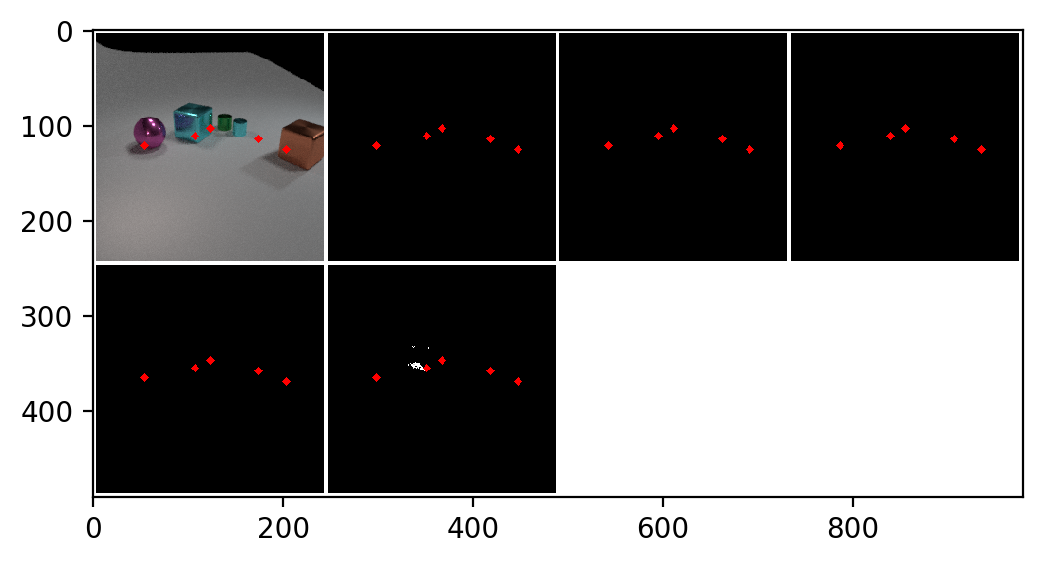

In [100]:
# Object center locations
ii = full.copy()
for a in ann['objects']:
    x = a['pixel_coords'][0]
    y = a['pixel_coords'][1]
    for i in ii:
        i = cv2.circle(i, (x, y), 2, (255,0,0), 4)
    #pts = np.array(a['pixel_bbox'])[:,:2].astype(int)
    #tl = (np.min(pts[:,0]), np.min(pts[:,1]))
    #br = (np.max(pts[:,0]), np.max(pts[:,1]))
    #ii = cv2.rectangle(ii, tl, br, (255,0,0), 1)

view_image(ii,200)

In [99]:
for a in ann['objects']:
    print(a['shape'], a['pixel_coords'])

sphere [200, 122, 10.372808456420898]
cube [171, 111, 11.209991455078125]
cylinder [104, 108, 10.682252883911133]
cube [120, 100, 12.270238876342773]
cylinder [51, 118, 10.640951156616211]


In [28]:
datapath = Path('/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/')
idx = 0
annpath = datapath / '{}.json'.format(idx)

with open(annpath, 'r') as f:
    ann = json.load(f)

In [29]:
ann['objects'][0]['pixel_coords']

[123, 158, 8.280657768249512]

In [30]:
datapath = Path('/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/')
idx = 1
annpath = datapath / '{}.json'.format(idx)

with open(annpath, 'r') as f:
    ann = json.load(f)

In [31]:
ann['objects'][0]['pixel_coords']

[123, 158, 8.280657768249512]